# 1. Import Module & Data

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import figure
import matplotlib.pyplot as plt
import math
import os
import time
import random
import gc
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [3]:
data_folder = '../data/'
os.makedirs(data_folder, exist_ok=True)

df = pd.read_csv(data_folder + 'aapl.csv')
df = df.iloc[:, 1:]
df

,Open,High,Low,Close,Volume,Close_SMA10,Close_SMA20,Close_SMA30,Close_EMA10,Close_EMA20,...,Close_long,Close_MACD,Close_SignalLine,Close_7D,Close_1D,Close_Momentum,Close1diff,Close_up,Close_down,Close_RSI
0,151.78,151.78,151.78,151.78,195.0,151.802,151.8685,151.851000,151.814923,151.837962,...,151.846566,-0.025605,-0.016996,151.80,151.80,0.000000,-0.02,0.00,-0.02,37.096774
1,151.78,151.78,151.78,151.78,465.0,151.803,151.8640,151.846333,151.808574,151.832442,...,151.841635,-0.026976,-0.018992,151.80,151.78,-0.000132,0.00,0.00,0.00,33.898305
2,151.75,151.75,151.65,151.69,1877.0,151.787,151.8525,151.837333,151.787015,151.818876,...,151.830403,-0.034922,-0.022178,151.81,151.78,-0.000198,-0.09,0.00,-0.09,28.358209
3,151.62,151.62,151.60,151.62,913.0,151.769,151.8365,151.826667,151.756648,151.799935,...,151.814817,-0.046334,-0.027009,151.81,151.69,-0.000790,-0.07,0.00,-0.07,29.687500
4,151.66,151.66,151.65,151.65,441.0,151.754,151.8210,151.824000,151.737258,151.785656,...,151.802609,-0.052353,-0.032078,151.81,151.62,-0.001252,0.03,0.03,0.00,22.413793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66784,166.28,166.33,166.28,166.33,1020.0,166.340,166.3450,166.359333,166.323779,166.337186,...,166.336513,-0.007955,0.005171,166.40,166.28,-0.000721,0.05,0.05,0.00,51.162791
66785,166.33,166.33,166.30,166.30,327.0,166.325,166.3450,166.351333,166.319455,166.333645,...,166.333808,-0.009644,0.002208,166.33,166.33,0.000000,-0.03,0.00,-0.03,42.307692
66786,166.30,166.35,166.30,166.35,3435.0,166.323,166.3500,166.349333,166.325009,166.335203,...,166.335008,-0.006868,0.000393,166.40,166.30,-0.000601,0.05,0.05,0.00,45.121951
66787,166.33,166.40,166.33,166.40,1519.0,166.323,166.3515,166.348667,166.338644,166.341374,...,166.339822,-0.000627,0.000189,166.35,166.35,0.000000,0.05,0.05,0.00,47.674419


### If you want Feature Engineering for uni-stock

In [4]:
#Feature Engineering Class 
class FeatureEngineering:
    def __init__(self, stock_name):
        self.stock_name = stock_name

    #Simple Moving Average
    def SMA(self,  data, column='Close', period=30):
        data = copy.deepcopy(data)
        data[column+f'_SMA{period}'] = data[column].rolling(period).mean()
        return data
    
    def SMA_(self,  data, column='Close', period=30):
        data = copy.deepcopy(data)
        return data[column].rolling(period).mean()

    #Exponential Moving Average
    def EMA(self, data, period=20, column='Close'):
        data = copy.deepcopy(data)
        data[column+f'_EMA{period}'] = data[column].ewm(span=period, adjust=False).mean()
        return data
    
    def EMA_(self, data, period=20, column='Close'):
        data = copy.deepcopy(data)
        return data[column].ewm(span=period, adjust=False).mean()
    
    #BollingerBand with SMA
    def Bollingerband(self, data, period=20, column='Close'):
        data = copy.deepcopy(data)
        
        data[column+f'_SMA{period}'] = self.SMA_(data, column=column, period=period)
        data[column+'_UB'] = data[column+f'_SMA{period}'] + 2*data[column+f'_SMA{period}'].std()
        data[column+'_LB'] = data[column+f'_SMA{period}'] - 2*data[column+f'_SMA{period}'].std()
        
        return data
    
    #MACD
    def MACD(self, data, period_long=26, period_short=12, period_signal=9, column='Close'):
        data = copy.deepcopy(data)
        
        data[column+'_short'] = self.EMA_(data, period=period_short, column=column)

        data[column+f'_long'] = self.EMA_(data, period=period_long, column=column)

        data[column+'_MACD'] = data[column+f'_short']- data[column+f'_long']

        #signal
        data[column+'_SignalLine'] = self.EMA_(data, period=period_signal, column=column+'_MACD')

        return data
    
    #Momentum
    def Momentum(self, data, period=7, column='Close'):
        data = copy.deepcopy(data)
        
        data[column+f'_{period}D'] = data[column].shift(period)
        data[column+'_1D'] = data[column].shift(1)
        data[column+'_Momentum'] = data[column+'_1D'] / data[column+f'_{period}D'] - 1
        
        return data
    
    #RSI
    def RSI(self, data, period=14, column='Close'):
        data = copy.deepcopy(data)
        
        data[column+'1diff'] = data[column].diff(1)
        
        delta = data[column].diff(1)
        delta = delta.dropna()

        up = delta.copy()
        down = delta.copy()
        up[up<0] = 0
        down[down>0] = 0
        data[column+'_up'] = up
        data[column+'_down'] = down

        AVG_Gain = self.SMA_(data, period=period, column=column+'_up')
        AVG_Loss = abs(self.SMA_(data, period=period, column=column+'_down'))
        RS = AVG_Gain / AVG_Loss

        RSI = 100.0 - (100.0/(1.0+RS))
        data[column+'_RSI'] = RSI
  
        return data
    
    #Get feature engineered data
    def get_data(self, train):
        #print('Feature Engineering...')
        
        self.train = copy.deepcopy(train)
        c = self.stock_name
        
        self.train = self.SMA(self.train, column=c, period=10)
        self.train = self.SMA(self.train, column=c, period=20)
        self.train = self.SMA(self.train, column=c, period=30)
        
        self.train = self.EMA(self.train, column=c, period=10)
        self.train = self.EMA(self.train, column=c, period=20)
        self.train = self.EMA(self.train, column=c, period=30)
        
        self.train = self.Bollingerband(self.train, column=c)
        self.train = self.MACD(self.train, column=c)
        self.train = self.Momentum(self.train, column=c)
        self.train = self.RSI(self.train, column=c)
        
        #print("Done!")
        
        return self.train

In [5]:
#fe = FeatureEngineering('AAPL')
#df_fe = fe.get_data(df.loc[:, ['AAPL']])

In [6]:
#df = pd.concat([df_fe.iloc[:, 1:], df], axis=1)
#df.dropna(inplace=True)
target_loc = pd.Index(df.columns.tolist()).get_loc('Close')
print(target_loc, len(df.columns))

3 24


In [7]:
train = df[:60000]
valid = df[60000:60000+3800]
test = df[60000+3800:]

print(len(train), len(valid), len(test))

sc = MinMaxScaler()
sc.fit(train.values)
train_sc = pd.DataFrame(sc.transform(train.values), columns=df.columns)
valid_sc = pd.DataFrame(sc.transform(valid.values), columns=df.columns)
test_sc = pd.DataFrame(sc.transform(test.values), columns=df.columns)

60000 3800 2989


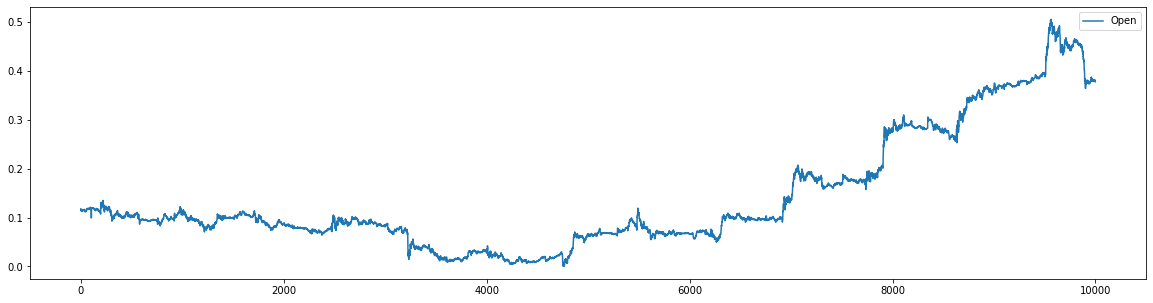

In [8]:
plt.figure(figsize=(20,5))
plt.plot(train_sc.iloc[:10000, 0], label=train_sc.columns[0])
plt.legend()
plt.show()

In [9]:
from torch import nn
from torch.utils.data import Dataset, WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
import torch

import os
import statistics
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import json
import matplotlib.pyplot as plt

SEED = 10
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

In [10]:
class MyDataset(Dataset):
    def __init__(self, data, window, pred, target_loc):
        self.data = torch.Tensor(data.values)
        self.window = window
        self.pred = pred
        self.target_loc = target_loc
        self.use_cols = [x for x in range(len(data.columns))] #if x != target_loc
        
        self.shape = self.__getshape__()
        self.size = self.__getsize__()

    def __getitem__(self, index):
        x = self.data[index:index+self.window, self.use_cols]
        y = self.data[index+self.window+self.pred-1, self.target_loc]
        return x, y

    def __len__(self):
        return len(self.data) - self.window - self.pred
    
    def __getshape__(self):
        return (self.__len__(), *self.__getitem__(0)[0].shape) # row, col
    
    def __getsize__(self):
        return (self.__len__())

In [11]:
batch_size = 64
num_workers = 4
pin_memory = True
device = 'cuda'
num_epoch = 150
lr = 1e-4
window = 120
pred_step = 10

In [12]:
train_dataset = MyDataset(train_sc, window, pred_step, target_loc)
valid_dataset = MyDataset(valid_sc, window, pred_step, target_loc)
test_dataset = MyDataset(test_sc, window, pred_step, target_loc)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                     drop_last=False, 
                                     num_workers=num_workers, pin_memory=pin_memory, shuffle=True) 
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, 
                                     drop_last=False, 
                                     num_workers=num_workers, pin_memory=pin_memory, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
                                     drop_last=False, 
                                     num_workers=num_workers, pin_memory=pin_memory, shuffle=False)

# 2. DynamicRouting CapsNet

In [13]:
result_folder = f'../check/drcaps/pred_stock_{pred_step}_aapl_1/'
os.makedirs(result_folder, exist_ok=True)

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


def squash(inputs, axis=-1):
    """
    The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param inputs: vectors to be squashed
    :param axis: the axis to squash
    :return: a Tensor with same size as inputs
    """
    norm = torch.norm(inputs, p=2, dim=axis, keepdim=True)
    scale = norm**2 / (1 + norm**2) / (norm + 1e-8)
    return scale * inputs


class DenseCapsule(nn.Module):
    """
    The dense capsule layer. It is similar to Dense (FC) layer. Dense layer has `in_num` inputs, each is a scalar, the
    output of the neuron from the former layer, and it has `out_num` output neurons. DenseCapsule just expands the
    output of the neuron from scalar to vector. So its input size = [None, in_num_caps, in_dim_caps] and output size = \
    [None, out_num_caps, out_dim_caps]. For Dense Layer, in_dim_caps = out_dim_caps = 1.
    :param in_num_caps: number of cpasules inputted to this layer
    :param in_dim_caps: dimension of input capsules
    :param out_num_caps: number of capsules outputted from this layer
    :param out_dim_caps: dimension of output capsules
    :param routings: number of iterations for the routing algorithm
    """
    def __init__(self, in_num_caps, in_dim_caps, out_num_caps, out_dim_caps, routings=3):
        super(DenseCapsule, self).__init__()
        self.in_num_caps = in_num_caps
        self.in_dim_caps = in_dim_caps
        self.out_num_caps = out_num_caps
        self.out_dim_caps = out_dim_caps
        self.routings = routings
        self.weight = nn.Parameter(0.01 * torch.randn(out_num_caps, in_num_caps, out_dim_caps, in_dim_caps))

    def forward(self, x):
        # x.size=[batch, in_num_caps, in_dim_caps]
        # expanded to    [batch, 1,            in_num_caps, in_dim_caps,  1]
        # weight.size   =[       out_num_caps, in_num_caps, out_dim_caps, in_dim_caps]
        # torch.matmul: [out_dim_caps, in_dim_caps] x [in_dim_caps, 1] -> [out_dim_caps, 1]
        # => x_hat.size =[batch, out_num_caps, in_num_caps, out_dim_caps]
        x_hat = torch.squeeze(torch.matmul(self.weight, x[:, None, :, :, None]), dim=-1)

        # In forward pass, `x_hat_detached` = `x_hat`;
        # In backward, no gradient can flow from `x_hat_detached` back to `x_hat`.
        x_hat_detached = x_hat.detach()

        # The prior for coupling coefficient, initialized as zeros.
        # b.size = [batch, out_num_caps, in_num_caps]
        b = Variable(torch.zeros(x.size(0), self.out_num_caps, self.in_num_caps)).cuda()
        #b = Variable(x_hat_detached).cuda()
        assert self.routings > 0, 'The \'routings\' should be > 0.'
        for i in range(self.routings):
            # c.size = [batch, out_num_caps, in_num_caps]
            c = F.softmax(b, dim=1)

            # At last iteration, use `x_hat` to compute `outputs` in order to backpropagate gradient
            if i == self.routings - 1:
                # c.size expanded to [batch, out_num_caps, in_num_caps, 1           ]
                # x_hat.size     =   [batch, out_num_caps, in_num_caps, out_dim_caps]
                # => outputs.size=   [batch, out_num_caps, 1,           out_dim_caps]
                outputs = squash(torch.sum(c[:, :, :, None] * x_hat, dim=-2, keepdim=True))
                #outputs = squash(torch.sum(c[:, :, :, :] * x_hat, dim=-2, keepdim=True))  
            else:  # Otherwise, use `x_hat_detached` to update `b`. No gradients flow on this path.
                #outputs = squash(torch.sum(c[:, :, :, None] * x_hat_detached, dim=-2, keepdim=True))
                outputs = squash(torch.sum(c[:, :, :, :] * x_hat, dim=-2, keepdim=True))  

                # outputs.size       =[batch, out_num_caps, 1,           out_dim_caps]
                # x_hat_detached.size=[batch, out_num_caps, in_num_caps, out_dim_caps]
                # => b.size          =[batch, out_num_caps, in_num_caps]
                b = b + torch.sum(outputs * x_hat_detached, dim=-1)
                #b = b+ (outputs*x_hat_detached)
        return torch.squeeze(outputs, dim=-2)


class PrimaryCapsule(nn.Module):
    """
    Apply Conv2D with `out_channels` and then reshape to get capsules
    :param in_channels: input channels
    :param out_channels: output channels
    :param dim_caps: dimension of capsule
    :param kernel_size: kernel size
    :return: output tensor, size=[batch, num_caps, dim_caps]
    """
    def __init__(self, in_channels, out_channels, dim_caps, kernel_size, stride=1, padding=0):
        super(PrimaryCapsule, self).__init__()
        self.dim_caps = dim_caps
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)

    def forward(self, x):
        outputs = self.conv2d(x)
        outputs = outputs.reshape(x.size(0), -1, self.dim_caps)
        return squash(outputs)

In [15]:
class CapsuleNet(nn.Module):
    """
    A Capsule Network on MNIST.
    :param input_size: data size = [channels, width, height]
    :param classes: number of classes
    :param routings: number of routing iterations
    Shape:
        - Input: (batch, channels, width, height), optional (batch, classes) .
        - Output:((batch, classes), (batch, channels, width, height))
    """
    def __init__(self, input_size, classes, routings):
        super(CapsuleNet, self).__init__()
        self.input_size = input_size
        self.classes = classes
        self.routings = routings

        # Layer 1: Just a conventional Conv2D layer
        self.conv1 = nn.Conv2d(input_size[0], 256, kernel_size=(1,9), stride=1, padding=0)

        # Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_caps, dim_caps]
        self.primarycaps = PrimaryCapsule(256, 256, 8, kernel_size=(1,9), stride=(1,2), padding=0)

        # Layer 3: Capsule layer. Routing algorithm works here.
        self.digitcaps = DenseCapsule(in_num_caps=32*52, in_dim_caps=8,
                                      out_num_caps=classes, out_dim_caps=16, routings=routings)

        # Decoder network.
        self.decoder = nn.Sequential(
            nn.Linear(16*classes, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 1),
            #nn.Sigmoid()
        )

        self.relu = nn.ReLU()

    def forward(self, x, y=None):
        #print(x.shape)
        x = self.relu(self.conv1(x.unsqueeze(2)))
        x = self.primarycaps(x)
        x = self.digitcaps(x)
        length = x.norm(dim=-1)
        if y is None:  # during testing, no label given. create one-hot coding using `length`
            index = length.max(dim=1)[1]
            y = Variable(torch.zeros(length.size()).scatter_(1, index.view(-1, 1).cpu().data, 1.).cuda())
        reconstruction = self.decoder((x * y[:, :, None]).view(x.size(0), -1))
        return reconstruction.view(-1, 1)

In [16]:
def caps_loss(y_true, y_pred, x, x_recon, lam_recon):
    """
    Capsule loss = Margin loss + lam_recon * reconstruction loss.
    :param y_true: true labels, one-hot coding, size=[batch, classes]
    :param y_pred: predicted labels by CapsNet, size=[batch, classes]
    :param x: input data, size=[batch, channels, width, height]
    :param x_recon: reconstructed data, size is same as `x`
    :param lam_recon: coefficient for reconstruction loss
    :return: Variable contains a scalar loss value.
    """
    y_true = y_true.squeeze()
    y_pred = y_pred.squeeze()
    x = x.squeeze()
    x_recon = x_recon.squeeze()
    
    L = y_true * torch.clamp(0.9 - y_pred, min=0.) ** 2 + \
        0.5 * (1 - y_true) * torch.clamp(y_pred - 0.1, min=0.) ** 2
    L_margin = L.sum(dim=1).mean()

    L_recon = nn.MSELoss()(x_recon, x)

    return L_margin + lam_recon * L_recon

In [17]:
model = CapsuleNet([24,window,1], 5, 1).to(device) 

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

In [18]:
model

CapsuleNet(
  (conv1): Conv2d(24, 256, kernel_size=(1, 9), stride=(1, 1))
  (primarycaps): PrimaryCapsule(
    (conv2d): Conv2d(256, 256, kernel_size=(1, 9), stride=(1, 2))
  )
  (digitcaps): DenseCapsule()
  (decoder): Sequential(
    (0): Linear(in_features=80, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=1024, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=1024, out_features=1, bias=True)
  )
  (relu): ReLU()
)

# 3. Model Training and Evaluation

In [19]:
train_loss_list = []
valid_loss_list = []
    
for epoch in range(0, num_epoch+1):
    model = model.train()

    train_loss = []
    for (x, y) in tqdm(train_loader, leave=False):
        x = x.to(device).transpose(1,2)
        y = y.to(device).squeeze()

        optimizer.zero_grad()
        outputs = model(x)

        loss = torch.sqrt(criterion(outputs.squeeze(), y.squeeze()))
        
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item())

    train_loss = np.mean(train_loss)
    
    model = model.eval()
    predictions = []
    answers = []
    valid_loss = []
    with torch.no_grad():
        for (x, y) in tqdm(valid_loader, leave=False):
            x = x.to(device).transpose(1,2)
            y = y.to(device).squeeze()
            answers.extend(y.detach().cpu().numpy())

            outputs = model(x)

            loss = torch.sqrt(criterion(outputs.squeeze(), y.squeeze()))
        
            predictions.extend(outputs.squeeze().detach().cpu().numpy())
            valid_loss.append(loss.item())    

    valid_loss = np.mean(valid_loss)
    #scheduler.step(valid_loss)
    
    print("epoch: {}/{} | trn_loss: {:.4f} | val_loss: {:.4f}".format(
                epoch, num_epoch, train_loss, valid_loss
            ))
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    
    if epoch % 10 ==0 :
        torch.save({
            'epoch': epoch,
            'model_state_dict' : model.state_dict(),
            'optimizer_state_dict' : optimizer.state_dict(),
            'criterion' : criterion
        }, result_folder + f'dr-pred-stock-{epoch}.pt')
        
    if (epoch==0) or (epoch>0 and (min(valid_loss_list[:-1])>valid_loss_list[-1])):
        torch.save({
            'epoch': epoch,
            'model_state_dict' : model.state_dict(),
            'optimizer_state_dict' : optimizer.state_dict(),
            'criterion' : criterion
        }, result_folder + f'dr-pred-stock-best.pt')

epoch: 0/150 | trn_loss: 0.0337 | val_loss: 0.0153


epoch: 1/150 | trn_loss: 0.0142 | val_loss: 0.0137


epoch: 2/150 | trn_loss: 0.0133 | val_loss: 0.0156


epoch: 3/150 | trn_loss: 0.0127 | val_loss: 0.0132


epoch: 4/150 | trn_loss: 0.0126 | val_loss: 0.0133


epoch: 5/150 | trn_loss: 0.0124 | val_loss: 0.0150


epoch: 6/150 | trn_loss: 0.0122 | val_loss: 0.0133


epoch: 7/150 | trn_loss: 0.0118 | val_loss: 0.0141


epoch: 8/150 | trn_loss: 0.0118 | val_loss: 0.0140


epoch: 9/150 | trn_loss: 0.0117 | val_loss: 0.0158


epoch: 10/150 | trn_loss: 0.0116 | val_loss: 0.0146


epoch: 11/150 | trn_loss: 0.0115 | val_loss: 0.0142


epoch: 12/150 | trn_loss: 0.0116 | val_loss: 0.0151


epoch: 13/150 | trn_loss: 0.0115 | val_loss: 0.0133


epoch: 14/150 | trn_loss: 0.0112 | val_loss: 0.0134


epoch: 15/150 | trn_loss: 0.0113 | val_loss: 0.0136


epoch: 16/150 | trn_loss: 0.0115 | val_loss: 0.0137


epoch: 17/150 | trn_loss: 0.0111 | val_loss: 0.0132


epoch: 18/150 | trn_loss: 0.0109 | val_loss: 0.0141


epoch: 19/150 | trn_loss: 0.0111 | val_loss: 0.0134


epoch: 20/150 | trn_loss: 0.0110 | val_loss: 0.0141


epoch: 21/150 | trn_loss: 0.0110 | val_loss: 0.0133


epoch: 22/150 | trn_loss: 0.0107 | val_loss: 0.0128


epoch: 23/150 | trn_loss: 0.0110 | val_loss: 0.0143


epoch: 24/150 | trn_loss: 0.0108 | val_loss: 0.0132


epoch: 25/150 | trn_loss: 0.0108 | val_loss: 0.0134


epoch: 26/150 | trn_loss: 0.0107 | val_loss: 0.0137


epoch: 27/150 | trn_loss: 0.0107 | val_loss: 0.0133


epoch: 28/150 | trn_loss: 0.0107 | val_loss: 0.0134


epoch: 29/150 | trn_loss: 0.0109 | val_loss: 0.0135


epoch: 30/150 | trn_loss: 0.0105 | val_loss: 0.0137


epoch: 31/150 | trn_loss: 0.0107 | val_loss: 0.0151


epoch: 32/150 | trn_loss: 0.0105 | val_loss: 0.0183


epoch: 33/150 | trn_loss: 0.0107 | val_loss: 0.0134


epoch: 34/150 | trn_loss: 0.0104 | val_loss: 0.0137


epoch: 35/150 | trn_loss: 0.0105 | val_loss: 0.0138


epoch: 36/150 | trn_loss: 0.0104 | val_loss: 0.0138


epoch: 37/150 | trn_loss: 0.0104 | val_loss: 0.0139


epoch: 38/150 | trn_loss: 0.0102 | val_loss: 0.0141


epoch: 39/150 | trn_loss: 0.0103 | val_loss: 0.0138


epoch: 40/150 | trn_loss: 0.0102 | val_loss: 0.0139


epoch: 41/150 | trn_loss: 0.0101 | val_loss: 0.0150


epoch: 42/150 | trn_loss: 0.0101 | val_loss: 0.0141


epoch: 43/150 | trn_loss: 0.0102 | val_loss: 0.0149


epoch: 44/150 | trn_loss: 0.0099 | val_loss: 0.0144


epoch: 45/150 | trn_loss: 0.0099 | val_loss: 0.0167


epoch: 46/150 | trn_loss: 0.0099 | val_loss: 0.0140


epoch: 47/150 | trn_loss: 0.0098 | val_loss: 0.0149


epoch: 48/150 | trn_loss: 0.0097 | val_loss: 0.0148


epoch: 49/150 | trn_loss: 0.0097 | val_loss: 0.0141


epoch: 50/150 | trn_loss: 0.0097 | val_loss: 0.0148


epoch: 51/150 | trn_loss: 0.0096 | val_loss: 0.0150


epoch: 52/150 | trn_loss: 0.0094 | val_loss: 0.0147


epoch: 53/150 | trn_loss: 0.0096 | val_loss: 0.0152


epoch: 54/150 | trn_loss: 0.0093 | val_loss: 0.0160


epoch: 55/150 | trn_loss: 0.0095 | val_loss: 0.0141


epoch: 56/150 | trn_loss: 0.0094 | val_loss: 0.0148


epoch: 57/150 | trn_loss: 0.0093 | val_loss: 0.0151


epoch: 58/150 | trn_loss: 0.0093 | val_loss: 0.0148


epoch: 59/150 | trn_loss: 0.0092 | val_loss: 0.0148


epoch: 60/150 | trn_loss: 0.0091 | val_loss: 0.0146


epoch: 61/150 | trn_loss: 0.0091 | val_loss: 0.0151


epoch: 62/150 | trn_loss: 0.0090 | val_loss: 0.0149


epoch: 63/150 | trn_loss: 0.0090 | val_loss: 0.0149


epoch: 64/150 | trn_loss: 0.0089 | val_loss: 0.0151


epoch: 65/150 | trn_loss: 0.0088 | val_loss: 0.0150


epoch: 66/150 | trn_loss: 0.0088 | val_loss: 0.0170


KeyboardInterrupt: 

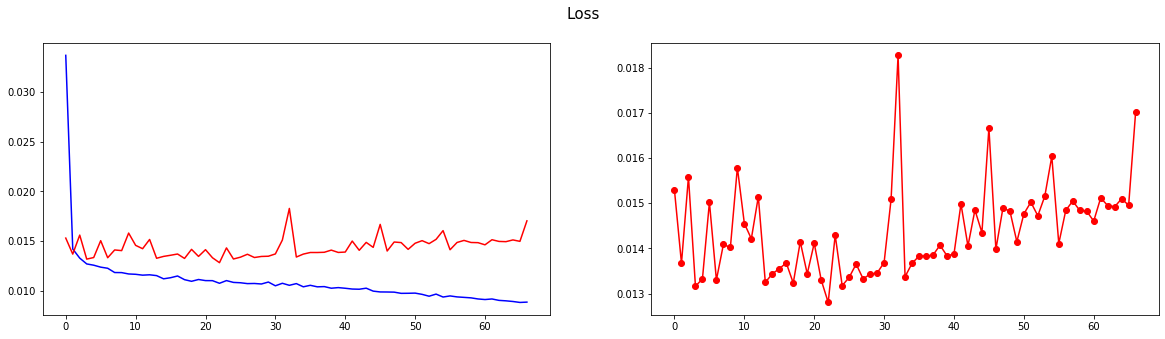

In [20]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

ax0 = ax[0]
ax0.plot(train_loss_list, c= 'blue')
ax0.plot(valid_loss_list, c='red')

ax1 = ax[1]
ax1.plot(valid_loss_list, c='red', marker='o')

fig.suptitle("Loss", fontsize=15)
plt.savefig(result_folder+'dr_loss.png')

### Performance Evaluation

In [21]:
checkpoint = torch.load(result_folder + 'dr-pred-stock-best.pt')
model.load_state_dict(checkpoint['model_state_dict']) #, strict=False)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
criterion = checkpoint['criterion']
print(checkpoint['epoch'])

22


In [22]:
model = model.eval()
test_loss = []
answers = []
predictions = []

with torch.no_grad():
    for (x, y) in tqdm(test_loader, leave=False):
        x = x.to(device).transpose(1,2)
        y = y.to(device).squeeze()

        outputs = model(x)

        loss = torch.sqrt(criterion(outputs.squeeze(), y))
        
        answers.extend(y.squeeze().detach().cpu().numpy())
        predictions.extend(outputs.squeeze().detach().cpu().numpy())
        test_loss.append(loss.item())  
        
test_loss = np.mean(test_loss)
print(f'test loss: {test_loss}')

test loss: 0.010398572414285608


In [ ]:
answers = pd.DataFrame(answers)
answers = pd.concat([answers, test_sc.iloc[window+pred_step:, 1:].reset_index(drop=True)], axis=1)
predictions = pd.DataFrame(predictions)
predictions = pd.concat([predictions, test_sc.iloc[window+pred_step:, 1:].reset_index(drop=True)], axis=1)
print(answers.shape, predictions.shape, test_sc.shape)

result_ans = pd.DataFrame(sc.inverse_transform(answers), columns = test_sc.columns)
result_pred= pd.DataFrame(sc.inverse_transform(predictions), columns = test_sc.columns)


result_ans.to_csv(result_folder + 'result_ans.csv')
result_pred.to_csv(result_folder + 'result_pred.csv')

In [ ]:
print(result_ans.shape)

In [ ]:
for i in range(0,1000,200):
    plt.figure(figsize=(20,3))
    plt.plot(result_ans.iloc[i:i+400, 0], c='black', ls=':', label = 'GroundTruth')
    plt.plot(result_pred.iloc[i:i+400, 0], c='blue', label='Reconstruction')
    plt.legend()
    plt.show()